In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [18]:
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting=3)
data.dropna(inplace=True)

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [21]:
example = data['verified_reviews'][51]
print(example)

"I'm still learning how to use it, but so far my Echo is great! The sound is actually much better than I was expecting."


In [22]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0031059375, 'roberta_neu': 0.013506233, 'roberta_pos': 0.9833878}


In [23]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [24]:
polarity_scores_roberta(example)

{'roberta_neg': 0.0031059375,
 'roberta_neu': 0.013506233,
 'roberta_pos': 0.9833878}

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [26]:
# Check for NaNs or non-strings
data['verified_reviews'].apply(type).value_counts()

verified_reviews
<class 'str'>    3149
Name: count, dtype: int64

In [27]:
sentiment_scores = data['verified_reviews'].apply(lambda x: sia.polarity_scores(x)).apply(pd.Series)
data = pd.concat([data, sentiment_scores], axis=1)

roberta_scores = data['verified_reviews'].apply(lambda x: polarity_scores_roberta(x)).apply(pd.Series)
data = pd.concat([data, roberta_scores], axis=1)


data

,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960
...,...,...,...,...,...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,0.000,0.620,0.380,0.6467,0.005170,0.078889,0.915941
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,0.000,1.000,0.000,0.0000,0.058853,0.408031,0.533116
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,0.028,0.738,0.234,0.9485,0.002146,0.011489,0.986366
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,0.087,0.827,0.087,0.0008,0.472854,0.439059,0.088087


In [29]:
# VADER sentiment label based on compound score
def vader_sentiment(row):
    if row['compound'] >= 0.05:
        return 'Positive'
    elif row['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# RoBERTa sentiment label based on highest score
def roberta_sentiment(row):
    scores = {
        'Negative': row['roberta_neg'],
        'Neutral': row['roberta_neu'],
        'Positive': row['roberta_pos']
    }
    return max(scores, key=scores.get)

# Apply both
data['vader_sentiment'] = data.apply(vader_sentiment, axis=1)
data['roberta_sentiment'] = data.apply(roberta_sentiment, axis=1)

# Display just the two new columns
data


,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,vader_sentiment,roberta_sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025,Positive,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209,Positive,Positive
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093,Negative,Positive
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505,Positive,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,0.000,0.620,0.380,0.6467,0.005170,0.078889,0.915941,Positive,Positive
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,0.000,1.000,0.000,0.0000,0.058853,0.408031,0.533116,Neutral,Positive
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,0.028,0.738,0.234,0.9485,0.002146,0.011489,0.986366,Positive,Positive
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,0.087,0.827,0.087,0.0008,0.472854,0.439059,0.088087,Neutral,Negative


In [36]:
pd.set_option('display.max_colwidth', None)


data[data['roberta_sentiment'] != data['vader_sentiment']][['verified_reviews','rating','feedback','vader_sentiment','roberta_sentiment']]

,verified_reviews,rating,feedback,vader_sentiment,roberta_sentiment
2,"""Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home.""",4,1,Negative,Positive
6,"""Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use. It IS a great alarm. If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response. She does not seem to be very smartbon politics yet.""",3,1,Positive,Negative
15,"""I love it, wife hates it.""",5,1,Positive,Negative
29,Just like the other one,5,1,Positive,Neutral
43,Tried to play certain broadway shows like Camelot and it gives ne the group Camelot.,5,1,Positive,Neutral
...,...,...,...,...,...
3127,works great but speaker is not the good for music. Will need to get a Bluetooth speaker.,4,1,Negative,Neutral
3137,Very convenient,5,1,Neutral,Positive
3138,"""Este producto llegó y a la semana se quedó sin olor, perdió toda su escencia, huele solo a alcohol""",5,1,Negative,Neutral
3146,"""Listening to music, searching locations, checking time, looking up weather. There are many more task to learn. It was simple to set up.""",5,1,Neutral,Positive


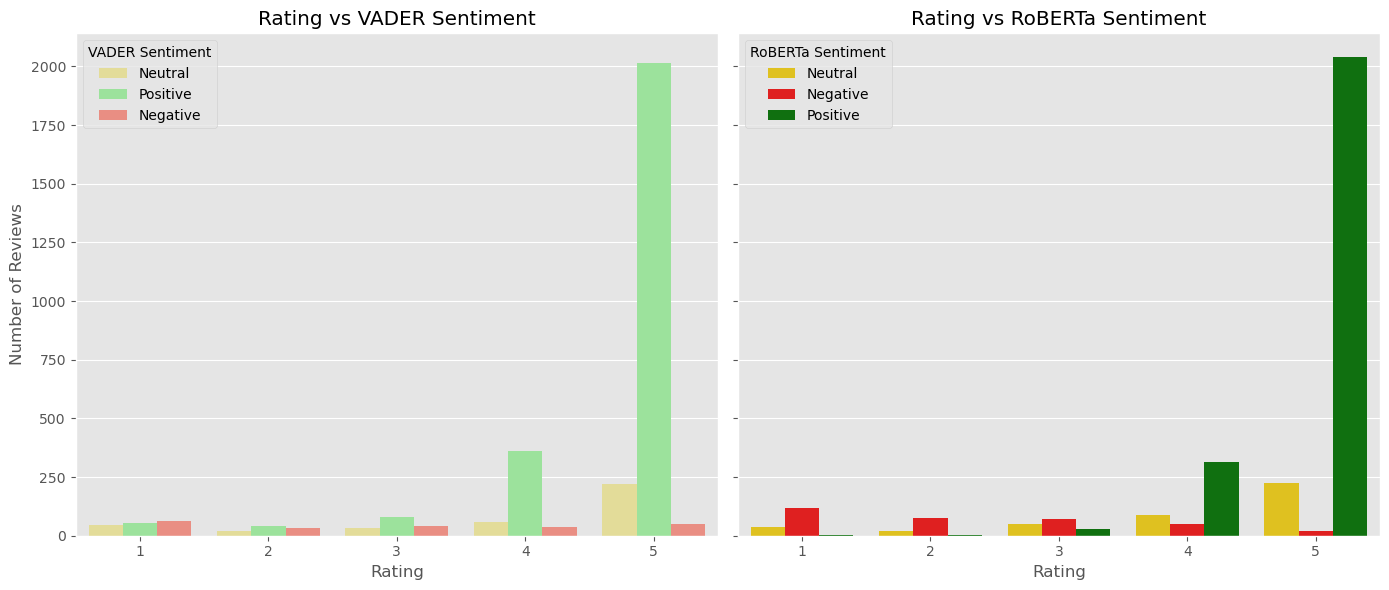

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot VADER sentiment vs rating
sns.countplot(data=data, x='rating', hue='vader_sentiment',
              palette={'Positive': 'lightgreen', 'Neutral': 'khaki', 'Negative': 'salmon'},
              ax=axes[0])
axes[0].set_title('Rating vs VADER Sentiment')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Number of Reviews')
axes[0].legend(title='VADER Sentiment')

# Plot RoBERTa sentiment vs rating
sns.countplot(data=data, x='rating', hue='roberta_sentiment',
              palette={'Positive': 'green', 'Neutral': 'gold', 'Negative': 'red'},
              ax=axes[1])
axes[1].set_title('Rating vs RoBERTa Sentiment')
axes[1].set_xlabel('Rating')
axes[1].legend(title='RoBERTa Sentiment')

plt.tight_layout()
plt.show()


In [39]:
data[(data['roberta_sentiment'] == 'Positive') & (data['rating'] < 3)]

,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,vader_sentiment,roberta_sentiment
1236,1,26-Jul-18,Black Spot,I would love this but there is no way to stop the screen from constantly scrolling through “things to try”. If Amazon would make this a setting I would change my review to 5 stars.,0,0.150,0.725,0.125,-0.2382,0.099940,0.241484,0.658576,Negative,Positive
1267,2,25-Jul-18,Black Spot,"""I switched to google. The amazon helper is more for shopping, and google is the tasks assistant.""",0,0.000,0.785,0.215,0.4767,0.026802,0.292285,0.680913,Positive,Positive
1540,1,30-Jul-18,Black Show,Fire HD does so much more. Over priced pair of speakers.,0,0.194,0.806,0.000,-0.3400,0.071927,0.312918,0.615155,Negative,Positive
2000,1,21-Jul-18,Black Plus,received the wrong product...was so excited to install it ...all excitement gone. Thank you Amazon.,0,0.134,0.431,0.435,0.7178,0.100678,0.171614,0.727709,Positive,Positive
2745,1,30-Jul-18,White Dot,The product sounded the same as the emoji speaker from five below my sister has ... and even that one has Bluetooth and doesn’t need to be plugged in. The only good thing about this is that you can speak to it.,0,0.000,0.934,0.066,0.4404,0.009141,0.099365,0.891493,Positive,Positive
3096,1,30-Jul-18,White Dot,The product sounded the same as the emoji speaker from five below my sister has ... and even that one has Bluetooth and doesn’t need to be plugged in. The only good thing about this is that you can speak to it.,0,0.000,0.934,0.066,0.4404,0.009141,0.099365,0.891493,Positive,Positive
